# Notebook looking at protein-protein interaction networks in A. thaliana
The purpose of this notebook is to answer the question of how networks genereated using phenotypic-text similarity based approaches through either embedding, vocabulary presence, or ontology annotation compare to or relate to networks that specify known protein-protein interactions. The hypothesis that these networks are potentially related is based on the idea that if two proteins interact, they are likely to be acting in a common pathway with a common biological function. If the phenotypic outcome of this pathway is observable and documented, then similarites between text describing the mutant phenotype for these genes may coincide with direct protein-protein interactions.

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_stringdb_information
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_edgelist_doc2vec, pairwise_edgelist_bagofwords, pairwise_edgelist_setofwords
from oats.graphs.pairwise import pairwise_edgelist_annotations, merge_edgelists, subset_edgelist_with_ids
from oats.graphs.pairwise import remove_self_loops
from oats.objectives.functions import balance_classes

mpl.rcParams["figure.dpi"] = 400
warnings.simplefilter('ignore')

## 1. Does the graph recapitulate known protein-protein interactions?
The different sections in this notebook correspond to different ways of determining if the graphs based on similarity between text descriptions, encodings of text descriptions, or annotations derived from text descriptions at all correspond to known protein-protein interactions in this dataset. The knowledge source about the protein-protein interactions for genes in this dataset is the STRING database (https://string-db.org/). The available entries in the whole dataset are subset to include only the genes that correspond to proteins that are atleast mentioned in the STRING database. This ways if a protein-protein interaction is not specified between two of the remaining genes, it is not because no interactions at all are documented either of those genes. The following cells focus on setting up a dataframe which specifies edge lists specific to each similarity method, and also a protein-protein interaction score for the genes which correspond to those two given nodes in the graphs.

In [57]:
# Reading in the entire dataset, subsetting for Arabidopsis and all annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.filter_by_species("ath")
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [58]:
# Reduce size of the dataset by removing genes not mentioned in the STRING.
string_database_file = "../data/group_related_files/string/3702.protein.links.detailed.v11.0.txt"
string_df, string_id_list = get_stringdb_information(string_database_file, dataset.get_name_to_id_dictionary())
dataset.filter_with_ids(string_id_list)
dataset.describe()

Number of rows in the dataframe: 3436
Number of unique IDs:            3436
Number of unique descriptions:   2809
Number of unique gene name sets: 3436
Number of species represented:   1


In [59]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
# Generating the pairwise edgelist and saving it as a dataframe.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = pairwise_edgelist_doc2vec(doc2vec_model, descriptions)
name_to_df_mapping["bagofwords"] = pairwise_edgelist_bagofwords(descriptions) 
name_to_df_mapping["setofwords"] = pairwise_edgelist_setofwords(descriptions)
name_to_df_mapping["ontology"] = pairwise_edgelist_annotations(annotations, ontology)
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
df = remove_self_loops(df)
print(df.head(8))
print(df.shape[0])

   from  to   doc2vec  bagofwords  setofwords  ontology
1     0   2  0.468285    0.750175    0.896774  0.427313
2     0   3  0.480444    1.000000    1.000000  0.844828
3     0   4  0.481082    0.966099    0.947917  0.425439
4     0   5  0.452204    0.708015    0.862745  0.697095
5     0   6  0.393862    0.799200    0.897638  0.399103
6     0   7  0.557884    0.835728    0.915584  0.498099
7     0   8  0.465764    0.846357    0.885714  0.476793
8     0   9  0.504262    0.866341    0.888889  0.510121
5901330


In [60]:
# Merging information from the protein-protein interaction database with this dataset.
df = df.merge(right=string_df, how="left", on=["from","to"])
df.fillna(value=0,inplace=True)
print(df.head(5))
print(df.shape)

   from  to   doc2vec  bagofwords  setofwords  ontology  combined_score
0     0   2  0.468285    0.750175    0.896774  0.427313             0.0
1     0   3  0.480444    1.000000    1.000000  0.844828             0.0
2     0   4  0.481082    0.966099    0.947917  0.425439             0.0
3     0   5  0.452204    0.708015    0.862745  0.697095             0.0
4     0   6  0.393862    0.799200    0.897638  0.399103           321.0
(5926812, 7)


### 1.1 Do the edges joining interacting proteins come from a different distribution?
This section uses a statistical test (Kolmogorov-Smirnov) to see if the distributions of edge weights which correspond to edges representing a known protein interaction come from a different distribution than the edge weights for edges that do not. This test was chosen because the sizes of the two samples can be different and there is no assumption of normality for the underlying distributions. 

In [61]:
METHODS = ["doc2vec", "bagofwords", "setofwords", "ontology"]

In [62]:
# Use KS test to see if protein-protein interaction edges come from a unique distribution.
ppi_pos_dict = {name:(df[df["combined_score"] > 0.00][name].values) for name in METHODS}
ppi_neg_dict = {name:(df[df["combined_score"] == 0.00][name].values) for name in METHODS}
results = {}
for name in METHODS:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    results[name] = {"int_mean":pos_mean,"not_mean":neg_mean,"n_int":pos_n,"n_not":neg_n,"D":stat,"p_value":p}  

print(pd.DataFrame(results).transpose())

            int_mean  not_mean     n_int      n_not         D        p_value
doc2vec     0.452282  0.459501  341604.0  5585208.0  0.029795  1.195711e-248
bagofwords  0.861321  0.892636  341604.0  5585208.0  0.080072   0.000000e+00
setofwords  0.943218  0.953522  341604.0  5585208.0  0.073769   0.000000e+00
ontology    0.590718  0.674709  341604.0  5585208.0  0.176367   0.000000e+00


### 1.2 What do those distributions of edge weights in the graph look like?
Visualization of the densities of the distributions that are tested in the previous cell. This is a check to see if the differences between the distribution of weights based on text-similarity corresponding to known protein-protein interactions are distinct enough those that do not to be practically useful in predicting interactions based on text-similarity.

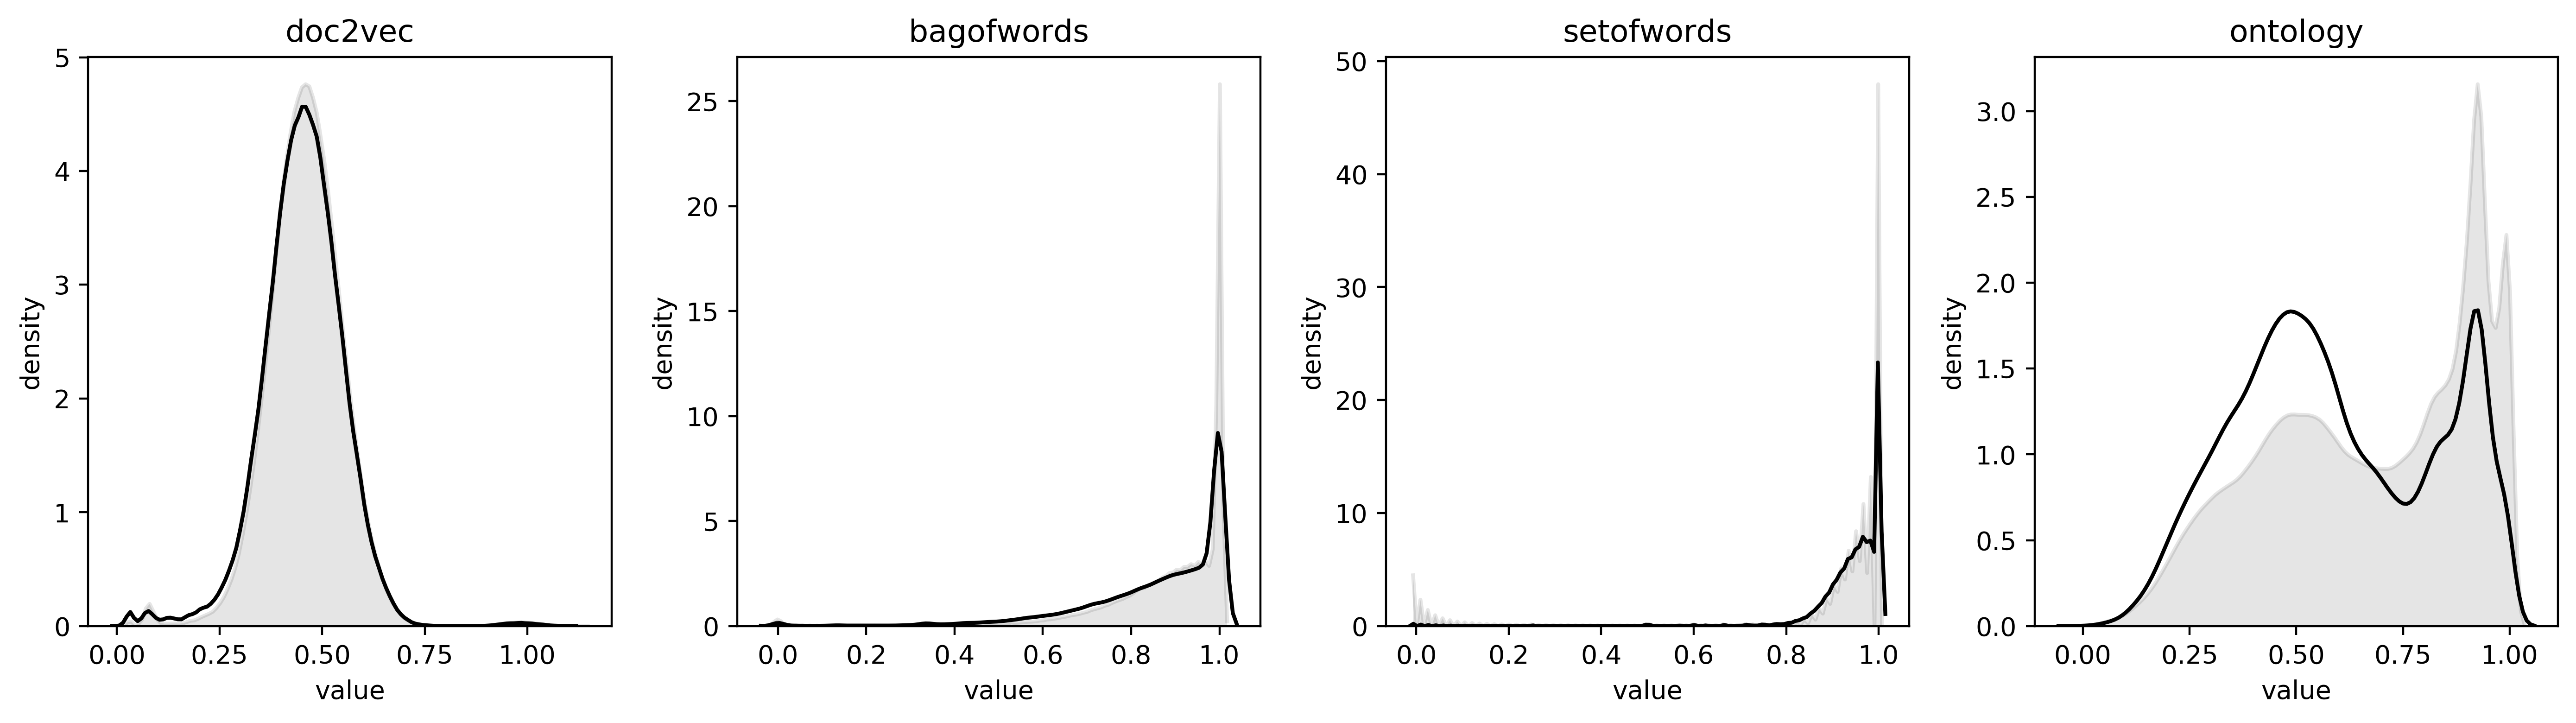

In [63]:
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for col,ax in zip(METHODS,axs.flatten()):
    ax.set_title(col)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[col], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(ppi_neg_dict[col], color="black", shade=True, alpha=0.1, ax=ax) 
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 1.3 Can we practically use the graph to predict known protein-protein interactions?
This is a different question than above, because the false positive rate is a limiting factor in how practically useful it would be to generate predictions about real protein interactions. In the case of the statistical test above, the sample distribution could be significantly different than the whole distribution of edge values even if there are many high valued edges which look like they could come from the sample distribution. In other words, the sample distribution could be distinct because of a lack of low edge weight values, not there could still be many high edge weight values that are not positive edges in this case, which represent false positives).

               auc baseline   n_int    n_not
doc2vec     0.0639   0.0576  341604  5585208
bagofwords  0.0749   0.0576  341604  5585208
setofwords  0.0724   0.0576  341604  5585208
ontology    0.0741   0.0576  341604  5585208


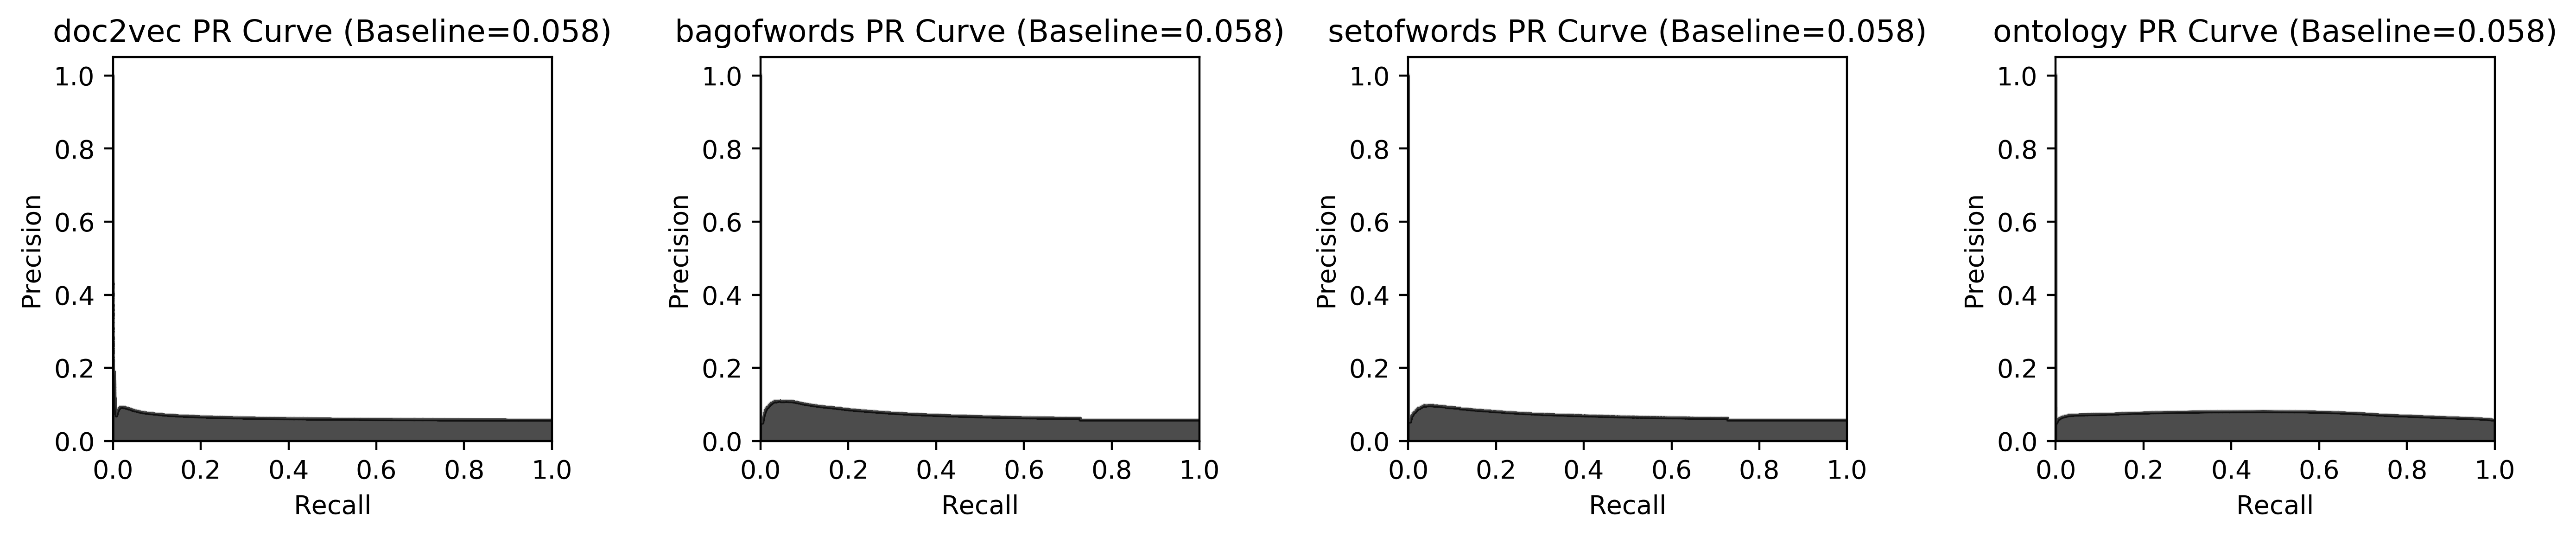

In [72]:
# Generate the targe class values, 1 indicating interaction and 0 indicating no interaction.
y_true_dict = {name:(np.where(df["combined_score"] > 0.000, 1, 0)) for name in METHODS}
y_prob_dict = {name:(1 - df[name].values) for name in METHODS}
results = {}
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(METHODS, axs.flatten()):
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    results[method] = {"auc":"{:.4f}".format(area),
                       "baseline":"{:.4f}".format(baseline),
                       "n_int":"{:.0f}".format(n_pos),
                       "n_not":"{:.0f}".format(n_neg)}
    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("{0} PR Curve (Baseline={1:0.3f})".format(method, baseline))
# Report the results and show the precision recall curves.
print(pd.DataFrame(results).transpose())
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 1.4 Can the graph be queried with one gene to successfully return other genes that it interacts with?
This question is similar (potentially overlapping) with a question asked above, which is to ask if genes in the network are connected by highly weighted edges to genes that gene interacts with in the protein-protein interaction data. If this is true, than we can query (return the nodes in order of greatest similarity to the query node) the network with one gene and get back genes that are likely to interact with it. The difference in how this is tested is that only the genes with atleast one known interaction partner are used as the queried proteins. This is mainly just a difference in the visualization? What's actually shown is where the interacting proteins are ranking against all the proteins in the dataset (which is just those proteins atleast mentioned in STRING for this species). When binning the ranks, the bin with the greatest count is the top ranks (1-10), but the ranks that fall in this bin are still a tiny fraction of the total number of returned ranks, so the answer to this question is effectively no.

In [73]:
# Get the list of gene IDs involved in interation with atleast one other protein in this dataset.
genes_with_partners = pd.unique(string_df[["from","to"]].dropna().values.ravel('K'))
partner_ranks_dict = {}

# For each method, obtain a list of the rankings in terms of similarity as measured by that method, using each gene
# iteratively as the query gene. The method of accessing the ranks is to first subset the edgelist dataframe to 
# contain only the rows where an edge involving the node of the query gene is specified, then the edge list is 
# sorted by the specific similarity score for that method, so that the indices of edges where the protein-protein
# interaction score is non-zero will correspond directly to ranks.
for name in METHODS:
    partner_ranks = []
    for gene_id in genes_with_partners:
        merged_df = pd.concat([df[df["from"]==gene_id],df[df["to"]==gene_id]],ignore_index=True)
        merged_df = merged_df.sort_values(by=[name]).reset_index(drop=True)
        indices = merged_df.query("combined_score > 0.00").index.tolist()
        partner_ranks.extend(indices)
    partner_ranks = [rank+1 for rank in partner_ranks]
    partner_ranks_dict[name] = partner_ranks
    print("finished with {}".format(name))

finished with doc2vec
finished with bagofwords
finished with setofwords
finished with ontology


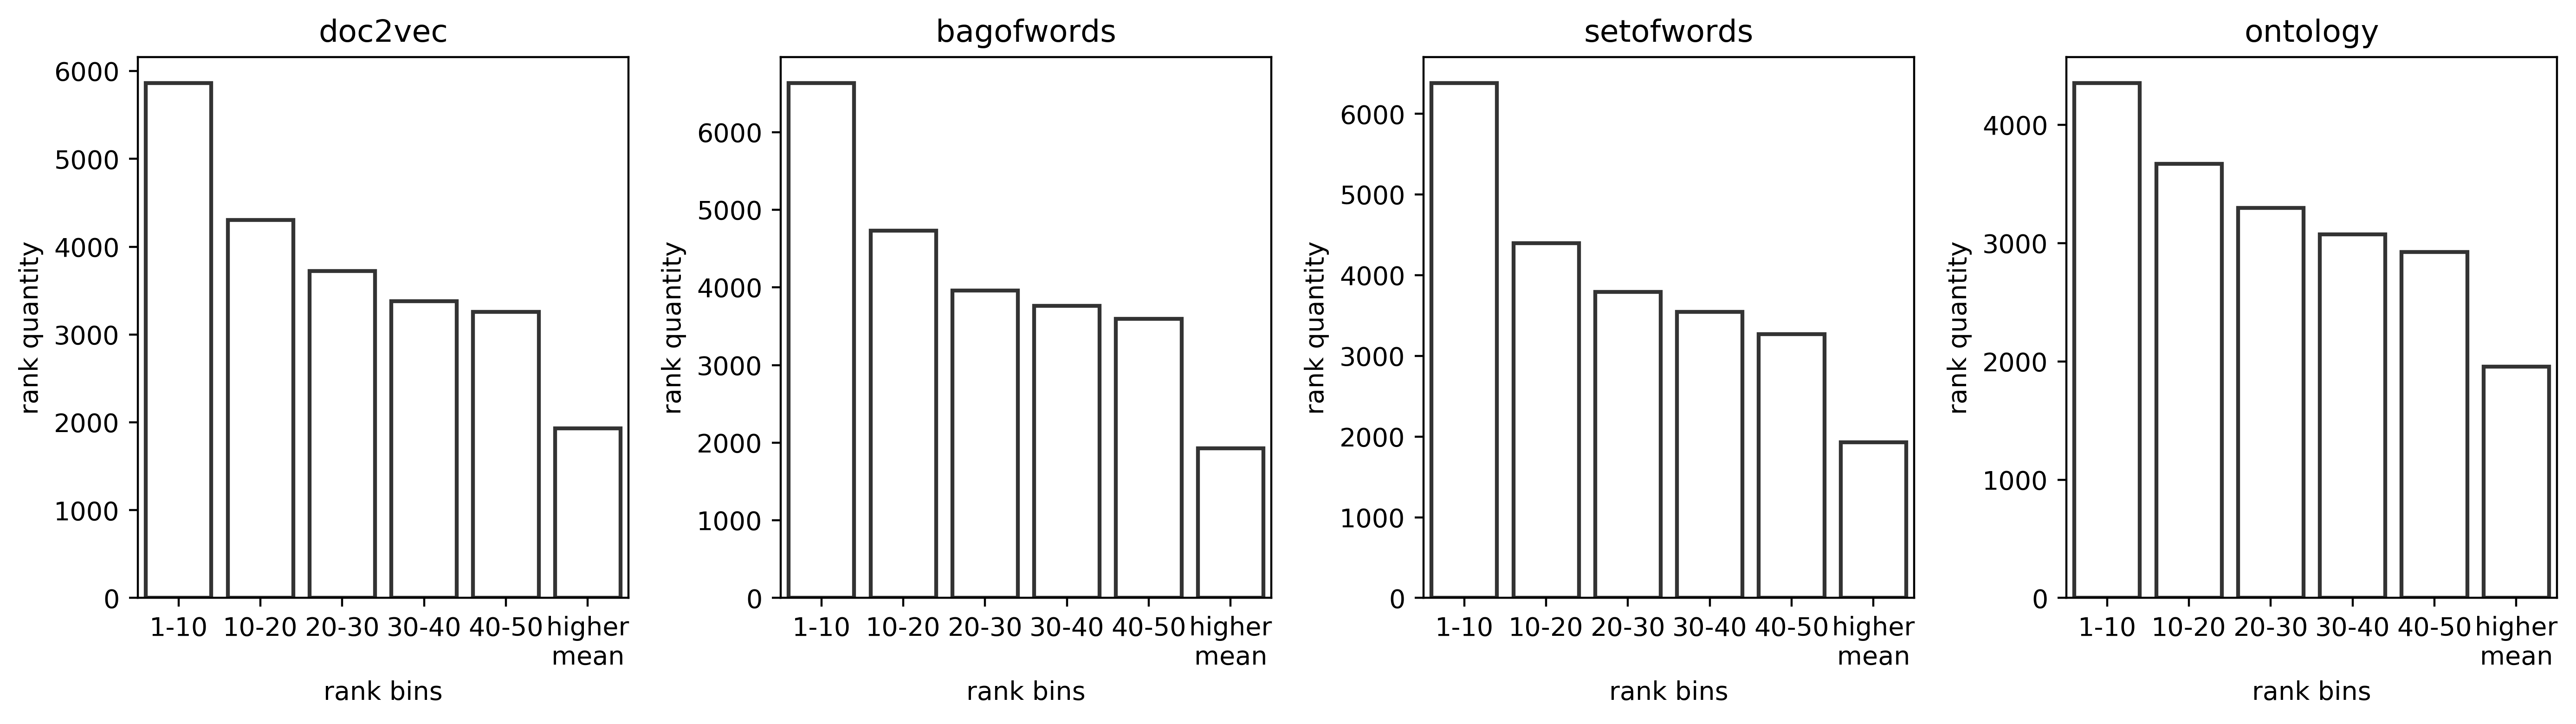

In [69]:
# Set these values to be able to make the large (rightmost) bin an average of all encompassed smaller bins.
# This way the size of that column can be reasonably compared to the columns to its left.
max_rank = len(pd.unique(df[["from","to"]].values.ravel('K')))
bins = [1,10,20,30,40,50,max_rank]
small_bin_size = 10
large_bin_size = (max_rank-50)
ratio = large_bin_size/small_bin_size

# Generate the barplots for each method.
num_plots, plots_per_row, row_width, row_height = (len(METHODS), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(METHODS,axs.flatten()):
    partner_ranks = partner_ranks_dict[name]
    ax.set_title(name)
    ax.set_xlabel("rank bins")
    ax.set_ylabel("rank quantity")
    counts,bin_edges = np.histogram(partner_ranks, bins)
    bin_labels = ["{}-{}".format(bin_edges[i],bin_edges[i+1]) for i in range(len(bin_edges)-1)]
    counts[-1] = counts[-1]/ratio    # Adjust the large bin column to reflect average of encompassed smaller bins.
    bin_labels[-1] = "higher\nmean"  # Change the label of that bin to reflect this change.
    sns.barplot(x=bin_labels,y=counts,linewidth=1.5,facecolor="white",alpha=0.8,errcolor=".2",edgecolor="black",ax=ax)

fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()